In [29]:
from functools import partial
from pathlib import Path
from typing import Optional, Tuple

import cv2
import fire
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from accelerate import Accelerator
from PIL import Image
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm
#from rhm_map import apply_sinkhorn
import random

import extract_utils

torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)

bbox_features_file = './data/VOC2012/multi_region_bboxes/laplacian/bbox_features.pth'
output_file = './data/VOC2012/multi_region_bboxes/laplacian/bbox_clusters.pth'

bbox_list = torch.load(bbox_features_file)
total_num_boxes = sum(len(d['bboxes']) for d in bbox_list)
print(f'Loaded bounding box list. There are {total_num_boxes} total bounding boxes with features.')

# Loop over boxes and stack features with PyTorch, because Numpy is too slow
print(f'Stacking and normalizing features')
all_features = torch.cat([bbox_dict['features'] for bbox_dict in bbox_list], dim=0)  # (numBbox, D)
all_features = all_features / torch.norm(all_features, dim=-1, keepdim=True)  # (numBbox, D)f
all_features = all_features.numpy()
print(all_features.shape)

Loaded bounding box list. There are 239750 total bounding boxes with features.
Stacking and normalizing features
(239750, 384)


|Num Clusters | MaxIter | Architecture| Mean IoU|
| --- | --- | --- | --- |
| **21** | 200  | KMeans L2  | 25.56|
| **21** | 200  | KMeans cos | 26.42, 24.55|
| **21** | 20  | KMeans cos + OT | 25.25, 23.80 |
| **21** | 200  | KMeans norm/std + L2 | 24.09 |
| **21** | 200  | KMeans norm/std + cos | 24.22 |
| **21** | 20  | KMeans norm/std + cos + OT | 23.69 |
| **21** | 20  | Crop Masked Attn | 23.66 |
| **21** | 20  | Crop CLS token without last ATTN | 20.30 |
| **21** | 20  | Crop CLS token with Attn |  22.19|
| **21** | 20  | Crop CLS token with Attn Forward Pass |  20.91, 16.87|

In [3]:
import torch
from torch import Tensor, nn

import math
from typing import Tuple, Type
    
class Attention(nn.Module):
    """
    An attention layer that allows for downscaling the size of the embedding
    after projection to queries, keys, and values.
    """

    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        downsample_rate: int = 1,
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.internal_dim = embedding_dim // downsample_rate
        self.num_heads = num_heads
        assert self.internal_dim % num_heads == 0, "num_heads must divide embedding_dim."

        self.q_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.k_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.v_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.out_proj = nn.Linear(self.internal_dim, embedding_dim)

    def _separate_heads(self, x: Tensor, num_heads: int) -> Tensor:
        b, n, c = x.shape
        x = x.reshape(b, n, num_heads, c // num_heads)
        return x.transpose(1, 2)  # B x N_heads x N_tokens x C_per_head

    def _recombine_heads(self, x: Tensor) -> Tensor:
        b, n_heads, n_tokens, c_per_head = x.shape
        x = x.transpose(1, 2)
        return x.reshape(b, n_tokens, n_heads * c_per_head)  # B x N_tokens x C

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        # Input projections
        q = self.q_proj(q)
        k = self.k_proj(k)
        v = self.v_proj(v)

        # Separate into heads
        q = self._separate_heads(q, self.num_heads)
        k = self._separate_heads(k, self.num_heads)
        v = self._separate_heads(v, self.num_heads)

        # Attention
        _, _, _, c_per_head = q.shape
        attn = q @ k.permute(0, 1, 3, 2)  # B x N_heads x N_tokens x N_tokens
        attn = attn / math.sqrt(c_per_head)
        attn = torch.softmax(attn, dim=-1)

        # Get output
        out = attn @ v # B x N_heads x N_tokens x C_per_head
        out = self._recombine_heads(out)
        out = self.out_proj(out)

        return out

class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.ReLU,
        skip_connection: bool = False,
        layer_norm: bool = False,
        dropout: float = 0.1
        
    ) -> None:
        super().__init__()
        
        self.skip_connection = skip_connection
        self.layer_norm = layer_norm
        
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.act = act()
        
        if self.layer_norm:
            self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mlp_out = self.lin2(self.dropout(self.act(self.lin1(x))))
        if self.skip_connection:
            mlp_out = x + mlp_out
        if self.layer_norm:
            mlp_out = self.norm(mlp_out)
        return mlp_out

### Method 1: KMean as Attn + MLP

In [4]:
class KMeanAttentionBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int = 2048,
        num_clusters: int = 21,
        activation: Type[nn.Module] = nn.ReLU,
        skip_connection: bool = True,
        layer_norm: bool = True,
        dropout: float = 0.1
    ) -> None:
        """
        Arguments:
          embedding_dim (int): the channel dimension of the embeddings
          num_heads (int): the number of heads in the attention layers
          mlp_dim (int): the hidden dimension of the mlp block
          num_clusters (int): number of clusters
          activation (nn.Module): the activation of the mlp block
        """
        super().__init__() 
        # Initialize claster centers embedings
        self.cluster_centers = torch.nn.Parameter(data=torch.randn(num_clusters, embedding_dim) / math.sqrt(embedding_dim / 2), requires_grad=True)
        
        # Attention Block
        self.self_attn = Attention(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.mlp = MLPBlock(embedding_dim, mlp_dim, activation, skip_connection, layer_norm, dropout=dropout)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(
        self, bbox_features: Tensor) -> Tuple[Tensor, Tensor]:
        # Self attention block
        attn_out = self.self_attn(q=bbox_features, k=self.cluster_centers.unsqueeze(dim=0), v=self.cluster_centers.unsqueeze(dim=0))
        updated_clusters = bbox_features + attn_out
        updated_clusters = self.norm1(updated_clusters)

        # MLP block
        updated_clusters = self.mlp(updated_clusters)
        
        return updated_clusters.squeeze(), self.cluster_centers

In [7]:
from torchmetrics.functional.pairwise import pairwise_cosine_similarity
from torch.linalg import matrix_norm

def kmean_loss(features, cluster_centers, gamam=1.0, add_variance = False):
    """
        fetaures: (N, C)
        cluster_centers: (K, C)
    """
    min_cluster_size = len(features) // (len(cluster_centers)**2)
    max_cluster_size = len(features) // (len(cluster_centers) ** 0.5)
    output = F.relu(pairwise_cosine_similarity(features, cluster_centers)) # (N, K) 
    coverage = torch.mean(F.relu(1-output.sum(dim=1))) + torch.mean(F.relu(min_cluster_size - output.sum(dim=0))) + torch.mean(F.relu(output.sum(dim=0)-max_cluster_size))
    cluster_intersections = output.T@output # (K, K)
    cluster_intersections[range(len(cluster_centers)), range(len(cluster_centers))] = 0.0
    disjointness = torch.sum(cluster_intersections)
    loss = coverage + gamam*disjointness
    if add_variance:
        clusters_assig = torch.argmax(output, dim=-1)
        for k in range(len(cluster_centers)):
            cluster_k = features[clusters_assig == k]
            cluster_variance_ = torch.sum((cluster_k - torch.mean(cluster_k, dim=0))**2)
            loss += cluster_variance_
    return loss
    

In [8]:
BATCH_SIZE = 4096
EPOCHS = 500
NUM_CLUSTERS = 21
EMB_DIM = all_features.shape[1]
NUM_HEADS = 1

train_data = torch.tensor(all_features)

In [9]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

cuda


In [11]:
import gc

def clear_gpu():
    torch.cuda.empty_cache()
    print(gc.collect())

In [13]:
clear_gpu()

0


In [337]:
from torch import optim 

model = KMeanAttentionBlock(num_clusters = NUM_CLUSTERS, embedding_dim=EMB_DIM, num_heads=NUM_HEADS, mlp_dim=512).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)

In [338]:
model

KMeanAttentionBlock(
  (self_attn): Attention(
    (q_proj): Linear(in_features=384, out_features=384, bias=True)
    (k_proj): Linear(in_features=384, out_features=384, bias=True)
    (v_proj): Linear(in_features=384, out_features=384, bias=True)
    (out_proj): Linear(in_features=384, out_features=384, bias=True)
  )
  (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (mlp): MLPBlock(
    (lin1): Linear(in_features=384, out_features=512, bias=True)
    (lin2): Linear(in_features=512, out_features=384, bias=True)
    (act): ReLU()
  )
  (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)

In [440]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import clear_output


def train(train_data, model, optimizer, epochs = EPOCHS, batch_size = BATCH_SIZE):
    model.train()
    loss_history = []
    weight_norm = []

    torch.autograd.set_detect_anomaly(True)

    for epoch in tqdm(range(epochs)):
        epoch_loss = []
        shuffled_train_data = train_data[torch.randperm(len(train_data))]
        for i, batch_id in enumerate(tqdm(range(0, len(shuffled_train_data), batch_size), position=0, leave=True)):
            batch = shuffled_train_data[batch_id:batch_id+batch_size].unsqueeze(dim=0).to(device)
            updated_features, cluster_centers = model(batch)
            loss = kmean_loss(updated_features, cluster_centers)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #weight_norm.append((torch.min(model.cluster_centers).cpu().item(), torch.max(model.cluster_centers).cpu().item()))
            epoch_loss.append(loss.item())
        
        loss_history.append(np.mean(epoch_loss))
        
        clear_output()
        print(f"Epoch {epoch}, Train loss: {loss_history[-1]}") #, Min weight: {weight_norm[-1][0]}, Max weight: {weight_norm[-1][1]} ")
        plt.figure(figsize=(12, 8))
        plt.plot(loss_history, label='train loss')
        #plt.plot(weight_norm, label='weight norm')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.yscale('log')
        # plt.ylim([0, 2])
        plt.legend(loc='best')
        plt.show()
        
    return model

Epoch 499, Train loss: 0.516930672576872


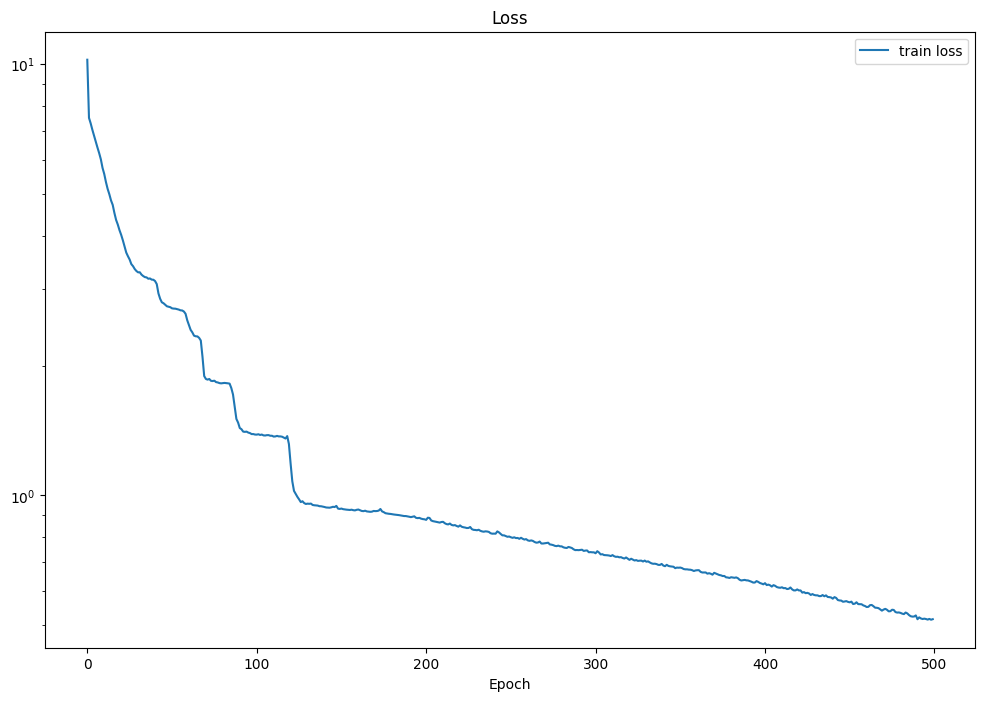

100%|██████████| 500/500 [15:20<00:00,  1.84s/it]


In [143]:
# Attn + MLP

model = train(train_data, model, optimizer)

Num Clusters | Min Cluster Size Threshold| Max Cluster Size Threshold| Optimizer | LR | Epochs | Train Loss| Mean IoU|
| --- | --- | --- | --- | --- | --- | --- | --- |
| 20 | DSS | DSS | DSS | DSS | DSS | DSS| **25.95** |
| 20 | 1 / k**(1.5) | None | AdamW | 3e-5 | 250 | 25.1895| |
| 20 | 1 / k**(1.5) | None | AdamW | 3e-4 | 250 | 41.01| |
| 20 | 1 / k**(2) | None | AdamW | 3e-5 | 250 | 0.846|  |
| 20 | 1 / k**(2) | None | AdamW | 2e-5 | 250 | 0.9272| 26.72 |
| 20 | 1 / k**(2) | 1 / k**(0.5) | AdamW | 3e-5 | 250 | 0.864| 27.23|
| 20 | 1 / k**(2) | 1 / k**(0.7) | AdamW | 3e-5 | 300 | 0.797| 27.11|
| 20 | 1 / k**(2) | 1 / k**(0.5) | AdamW | 3e-5 | 300 | 0.7878| **28.11**|
| 20 | 1 / k**(2) | 1 / k**(0.5) | AdamW | 3e-5 | 500 | 0.432| 24.31|
| **21** | 1 / k**(2) | 1 / k**(0.5) | AdamW | 3e-5 | 500 | 0.5169| **29.64**|
| **21** | DSS | DSS | DSS | DSS | DSS | DSS| **27.69**|

In [19]:
def model_eval(model, train_data):
    model.eval()
    
    clusters = []
    output = None

    for i, batch_id in enumerate(tqdm(range(0, len(train_data), BATCH_SIZE), position=0, leave=True)):
        batch = train_data[batch_id:batch_id+BATCH_SIZE].unsqueeze(dim=0).to(device)
        features, cluster_centers = model(batch)
        output = F.relu(pairwise_cosine_similarity(features, cluster_centers))
        clusters.extend(list(map(lambda x: x.item(), list(torch.argmax(output, dim=-1).cpu()))))
    
    _indices, _counts = np.unique(clusters, return_counts=True)
    print(f'Cluster indices: {_indices.tolist()}')
    print(f'Cluster counts: {_counts.tolist()}')
    return clusters

In [31]:
def model_save(model, clusters, model_name, bbox_list=bbox_list, output_file=output_file):
    model.eval()
    torch.save(model.state_dict(), '{}.pth'.format(model_name))
    # Loop over boxes and add clusters
    idx = 0
    for bbox_dict in bbox_list:
        num_bboxes = len(bbox_dict['bboxes'])
        #del bbox_dict['features']  # bbox_dict['features'] = bbox_dict['features'].squeeze()
        bbox_dict['clusters'] = np.array(clusters[idx: idx + num_bboxes])
        idx = idx + num_bboxes
    # Save
    torch.save(bbox_list, output_file)
    print(f'Saved features to {output_file}')

In [26]:
bbox_list[0]['clusters']

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [20]:
def model_load(model, model_name):
    model.load_state_dict(torch.load('{}.pth'.format(model_name)))
    model.to(device)
    model.eval()
    return model

In [15]:
model = KMeanAttentionBlock(num_clusters = NUM_CLUSTERS, embedding_dim=EMB_DIM, num_heads=NUM_HEADS, mlp_dim=512)
model = model_load(model, 'transformer_kmeans_k_2_k_05_lr_3e5_500_epochs_21_clusters')
model

RuntimeError: Error(s) in loading state_dict for KMeanAttentionBlock:
	Missing key(s) in state_dict: "mlp.norm.weight", "mlp.norm.bias". 

### Method 2: KMean as a sequence of MLPs

In [447]:
class KMeanMLP(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        num_clusters: int = 21,
        mlp_dim: int = 2048,
        depth: int = 3,
        activation: Type[nn.Module] = nn.ReLU,
        skip_connection: bool = False,
        layer_norm: bool = False
    ) -> None:
        """
        Arguments:
          embedding_dim (int): the channel dimension of the embeddings
          num_heads (int): the number of heads in the attention layers
          mlp_dim (int): the hidden dimension of the mlp block
          num_clusters (int): number of clusters
          depth (int): depth of the network
          activation (nn.Module): the activation of the mlp block
        """
        super().__init__() 
        # Initialize claster centers embedings
        self.cluster_centers = torch.nn.Parameter(data=torch.randn(num_clusters, embedding_dim) / math.sqrt(embedding_dim / 2), requires_grad=True)
        # MLP blocks
        self.layers = nn.ModuleList()
        
        for i in range(depth):
            self.layers.append(MLPBlock(embedding_dim, mlp_dim, activation, skip_connection, layer_norm))

    def forward(self, bbox_features: Tensor) -> Tuple[Tensor, Tensor]: 
        for mlp in self.layers:
            bbox_features = mlp(bbox_features)
        return bbox_features.squeeze(), self.cluster_centers

#### Indentical

In [229]:
clear_gpu()

0


In [215]:
from torch import optim 

model = KMeanMLP(embedding_dim=EMB_DIM, num_clusters = NUM_CLUSTERS, mlp_dim=512, depth=0).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)
model

KMeanMLP(
  (layers): ModuleList()
)

Epoch 599, Train loss: 6.734584743693723


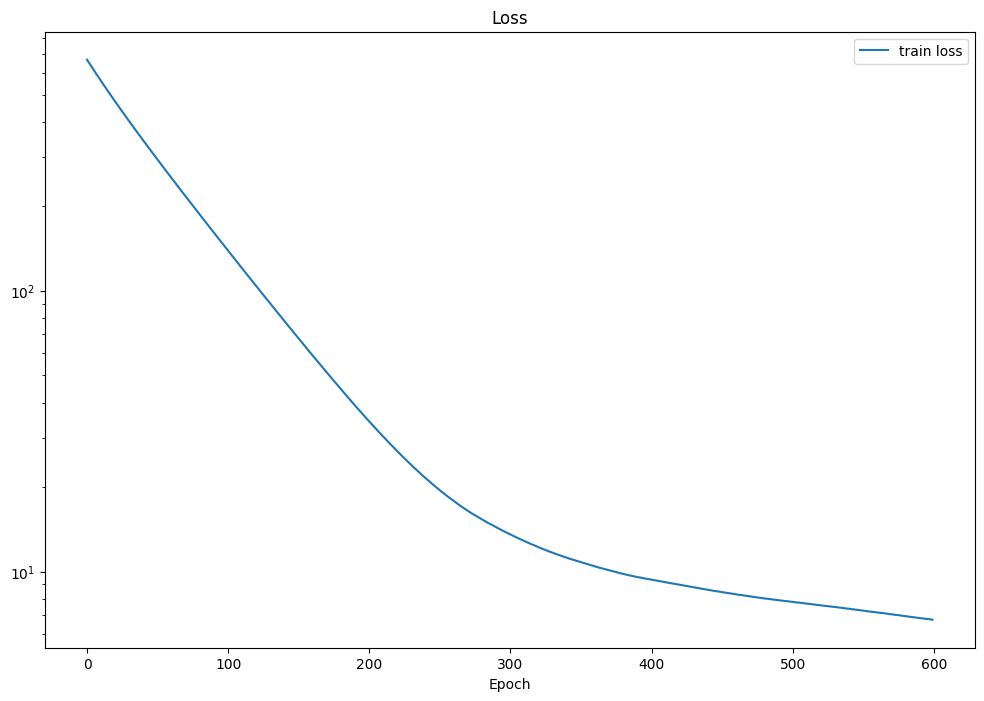

100%|██████████| 600/600 [08:10<00:00,  1.22it/s]


In [216]:
# Attn + MLP
model = train(train_data, model, optimizer, epochs=600)

In [217]:
clusters = model_eval(model, train_data)

100%|██████████| 59/59 [00:00<00:00, 117.12it/s]

Cluster indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Cluster counts: [77184, 4004, 1458, 1464, 12447, 15130, 2987, 16000, 15210, 15128, 8711, 9649, 11526, 66, 1628, 12061, 15922, 400, 16591, 512, 1672]


In [219]:
model_save(model, clusters, model_name='IndenticalBlock')

Saved features to ./data/VOC2012/multi_region_bboxes/laplacian/bbox_clusters.pth


#### MLP

In [277]:
clear_gpu()

24


In [243]:
from torch import optim 

model = KMeanMLP(embedding_dim=EMB_DIM, num_clusters = NUM_CLUSTERS, mlp_dim=512, depth=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)
model

KMeanMLP(
  (layers): ModuleList(
    (0): MLPBlock(
      (lin1): Linear(in_features=384, out_features=512, bias=True)
      (lin2): Linear(in_features=512, out_features=384, bias=True)
      (act): ReLU()
    )
  )
)

Epoch 499, Train loss: 0.46519349692231515


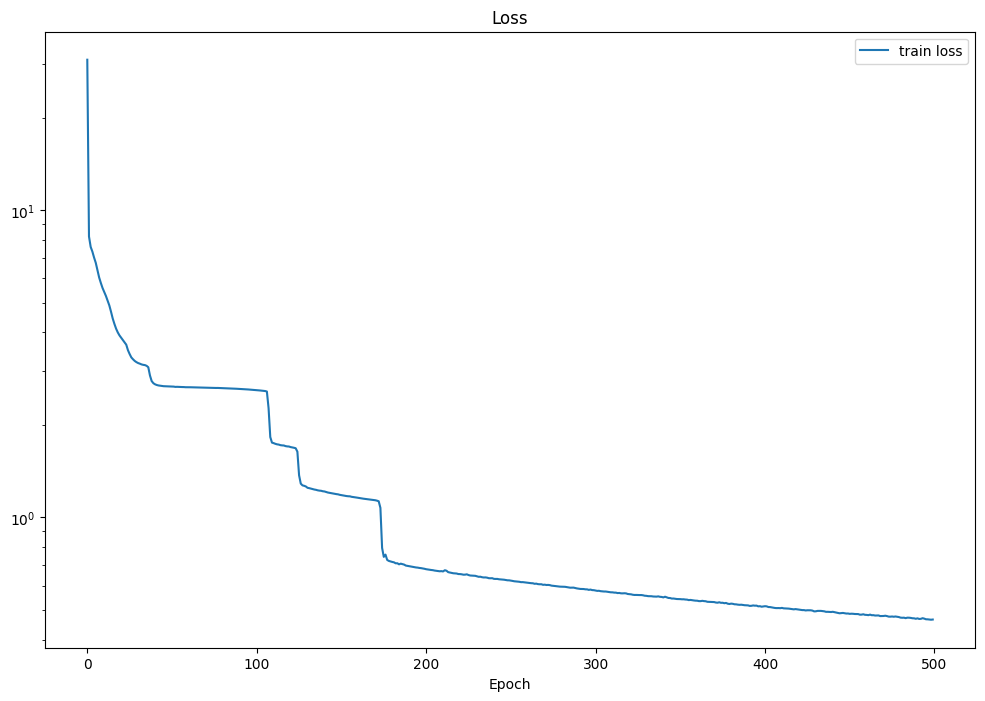

100%|██████████| 500/500 [08:46<00:00,  1.05s/it]


In [244]:
# Attn + MLP
model = train(train_data, model, optimizer, epochs=500)

In [245]:
clusters = model_eval(model, train_data)

100%|██████████| 59/59 [00:00<00:00, 102.32it/s]

Cluster indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Cluster counts: [37310, 12073, 19880, 7358, 16186, 6247, 8946, 9337, 6474, 6975, 10113, 8742, 7377, 10533, 13074, 5160, 7899, 11942, 18243, 6748, 9133]


In [246]:
model_save(model, clusters, model_name='MLPBlock', bbox_list=bbox_list, output_file=output_file)

Saved features to ./data/VOC2012/multi_region_bboxes/laplacian/bbox_clusters.pth


#### 2 x MLP

In [270]:
clear_gpu()

0


In [263]:
from torch import optim 

model = KMeanMLP(embedding_dim=EMB_DIM, num_clusters = NUM_CLUSTERS, mlp_dim=512, depth=2).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)
model

KMeanMLP(
  (layers): ModuleList(
    (0): MLPBlock(
      (lin1): Linear(in_features=384, out_features=512, bias=True)
      (lin2): Linear(in_features=512, out_features=384, bias=True)
      (act): ReLU()
    )
    (1): MLPBlock(
      (lin1): Linear(in_features=384, out_features=512, bias=True)
      (lin2): Linear(in_features=512, out_features=384, bias=True)
      (act): ReLU()
    )
  )
)

Epoch 599, Train loss: 1.4880353808403015


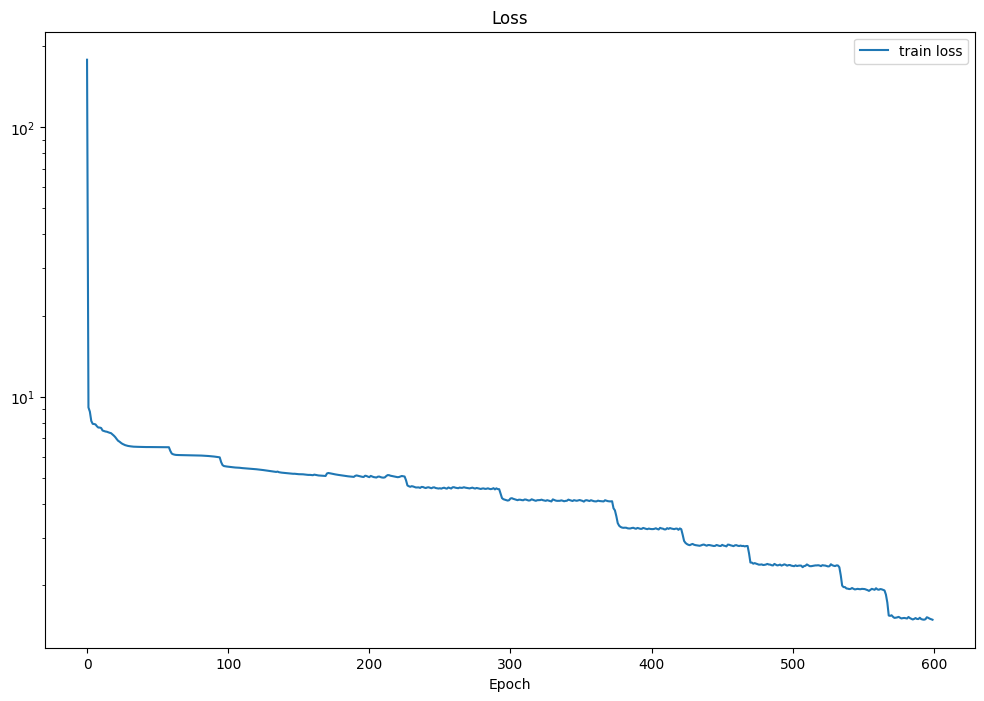

100%|██████████| 600/600 [12:36<00:00,  1.26s/it]


In [264]:
# Attn + MLP
model = train(train_data, model, optimizer, epochs=600)

In [265]:
clusters = model_eval(model, train_data)

100%|██████████| 59/59 [00:00<00:00, 76.76it/s]

Cluster indices: [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Cluster counts: [18397, 15074, 18745, 33651, 3399, 5691, 9630, 3532, 4588, 19642, 5902, 2823, 1746, 20093, 14616, 51702, 1, 7041, 3477]


In [272]:
model_save(model, clusters, model_name='2MLPBlock', bbox_list=bbox_list, output_file=output_file)

Saved features to ./data/VOC2012/multi_region_bboxes/laplacian/bbox_clusters.pth


In [324]:
clear_gpu()

0


In [325]:
from torch import optim 

model = KMeanMLP(embedding_dim=EMB_DIM, num_clusters = NUM_CLUSTERS, mlp_dim=512, depth=1, skip_connection = True, layer_norm=True).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)
model

KMeanMLP(
  (layers): ModuleList(
    (0): MLPBlock(
      (lin1): Linear(in_features=384, out_features=512, bias=True)
      (lin2): Linear(in_features=512, out_features=384, bias=True)
      (act): ReLU()
      (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
  )
)

Epoch 599, Train loss: 0.6678613414198665


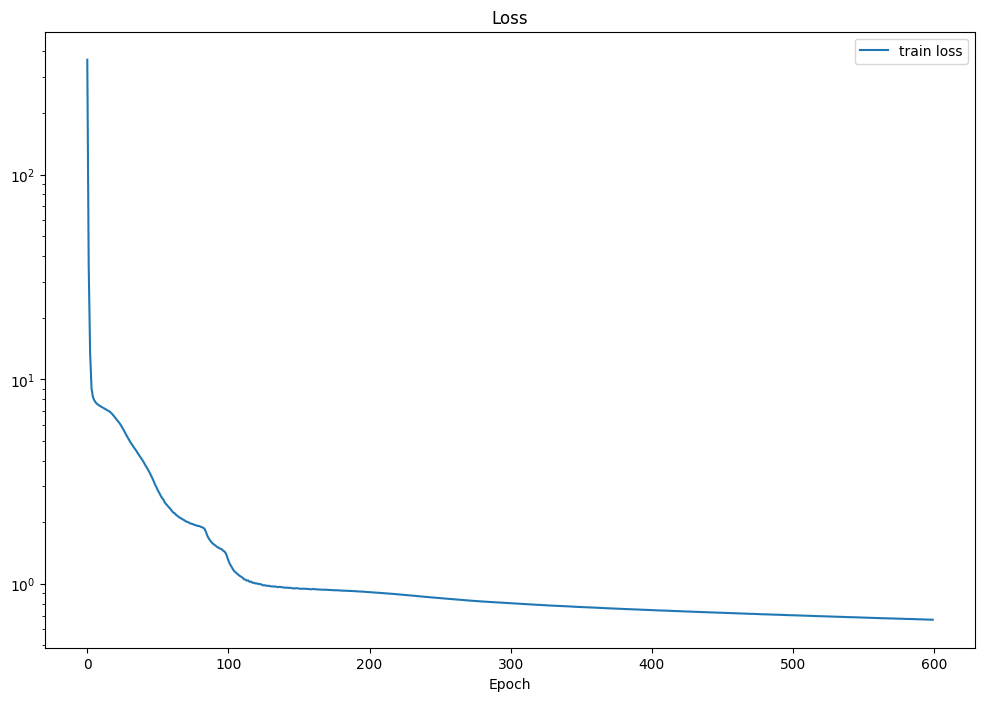

100%|██████████| 600/600 [11:12<00:00,  1.12s/it]


In [326]:
# Attn + MLP
model = train(train_data, model, optimizer, epochs=600)

In [327]:
clusters = model_eval(model, train_data)

100%|██████████| 59/59 [00:02<00:00, 26.09it/s]

Cluster indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Cluster counts: [45888, 9381, 5765, 12849, 9232, 7140, 7399, 11282, 7499, 7732, 6952, 5691, 13611, 6823, 20919, 8073, 11028, 6470, 6648, 12590, 16778]


In [328]:
model_save(model, clusters, model_name='MLPBlock_SkipConnection', bbox_list=bbox_list, output_file=output_file)

Saved features to ./data/VOC2012/multi_region_bboxes/laplacian/bbox_clusters.pth


In [387]:
clear_gpu()

0


In [388]:
from torch import optim 

model = KMeanMLP(embedding_dim=EMB_DIM, num_clusters = NUM_CLUSTERS, mlp_dim=512, depth=2, skip_connection = True, layer_norm=True).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)
model

KMeanMLP(
  (layers): ModuleList(
    (0): MLPBlock(
      (lin1): Linear(in_features=384, out_features=512, bias=True)
      (lin2): Linear(in_features=512, out_features=384, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (act): ReLU()
      (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
    (1): MLPBlock(
      (lin1): Linear(in_features=384, out_features=512, bias=True)
      (lin2): Linear(in_features=512, out_features=384, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (act): ReLU()
      (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
  )
)

Epoch 8, Train loss: 6.724150746555652


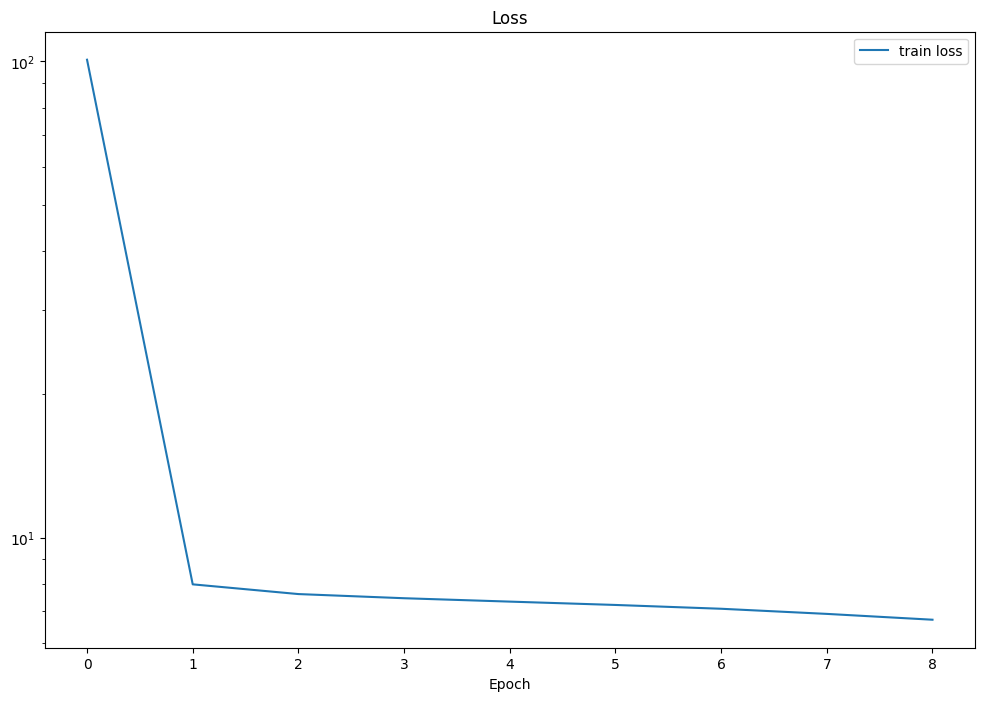

  2%|▏         | 9/500 [00:12<11:12,  1.37s/it]


KeyboardInterrupt: 

In [389]:
# Attn + MLP
model = train(train_data, model, optimizer, epochs=500)

In [356]:
clusters = model_eval(model, train_data)

100%|██████████| 59/59 [00:01<00:00, 54.58it/s]


Cluster indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Cluster counts: [53587, 16354, 5256, 4630, 14752, 6127, 11420, 9310, 5791, 5715, 7219, 13980, 7728, 18078, 19640, 4243, 5844, 2957, 14028, 7213, 5878]


In [301]:
model_save(model, clusters, model_name='2MLPBlock_SkipConnection', bbox_list=bbox_list, output_file=output_file)

Saved features to ./data/VOC2012/multi_region_bboxes/laplacian/bbox_clusters.pth


In [450]:
clear_gpu()

0


In [451]:
from torch import optim 

model = KMeanAttentionBlock(num_clusters = NUM_CLUSTERS, embedding_dim=EMB_DIM, num_heads=1, mlp_dim=512).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)
model

KMeanAttentionBlock(
  (self_attn): Attention(
    (q_proj): Linear(in_features=384, out_features=384, bias=True)
    (k_proj): Linear(in_features=384, out_features=384, bias=True)
    (v_proj): Linear(in_features=384, out_features=384, bias=True)
    (out_proj): Linear(in_features=384, out_features=384, bias=True)
  )
  (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (mlp): MLPBlock(
    (lin1): Linear(in_features=384, out_features=512, bias=True)
    (lin2): Linear(in_features=512, out_features=384, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (act): ReLU()
    (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)

Epoch 599, Train loss: 0.6365418807934906


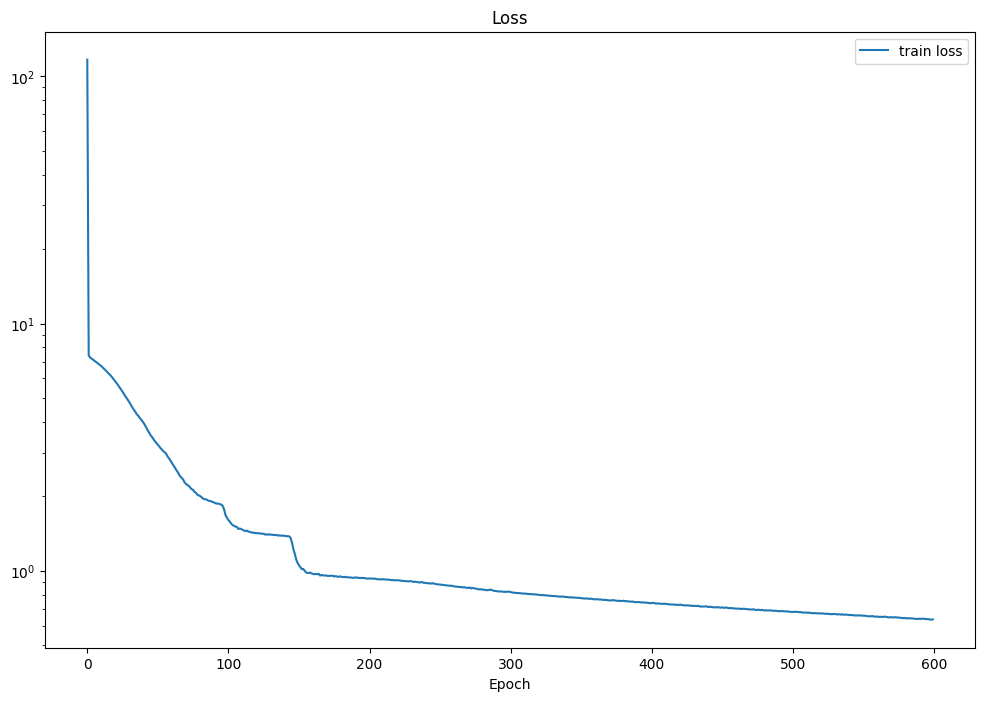

100%|██████████| 600/600 [20:08<00:00,  2.01s/it]


In [452]:
# Attn + MLP
model = train(train_data, model, optimizer, epochs=600)

In [32]:
clusters = model_eval(model, train_data)

100%|██████████| 59/59 [00:00<00:00, 110.20it/s]

Cluster indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Cluster counts: [53578, 7594, 9404, 6743, 8939, 5683, 15388, 10804, 9776, 14154, 6506, 19370, 9286, 7827, 5120, 6720, 17396, 5711, 5224, 8118, 6409]


In [33]:
model_save(model, clusters, model_name='AttnMLP8', bbox_list=bbox_list, output_file=output_file)

Saved features to ./data/VOC2012/multi_region_bboxes/laplacian/bbox_clusters.pth


In [16]:
model = KMeanAttentionBlock(num_clusters = NUM_CLUSTERS, embedding_dim=EMB_DIM, num_heads=NUM_HEADS, mlp_dim=512)
model = model_load(model, 'AttnMLP8')
model

KMeanAttentionBlock(
  (self_attn): Attention(
    (q_proj): Linear(in_features=384, out_features=384, bias=True)
    (k_proj): Linear(in_features=384, out_features=384, bias=True)
    (v_proj): Linear(in_features=384, out_features=384, bias=True)
    (out_proj): Linear(in_features=384, out_features=384, bias=True)
  )
  (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (mlp): MLPBlock(
    (lin1): Linear(in_features=384, out_features=512, bias=True)
    (lin2): Linear(in_features=512, out_features=384, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (act): ReLU()
    (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)

In [21]:
clusters = model_eval(model, train_data)

100%|██████████| 59/59 [00:00<00:00, 76.89it/s]


Cluster indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Cluster counts: [53578, 7594, 9404, 6743, 8939, 5683, 15388, 10804, 9776, 14154, 6506, 19370, 9286, 7827, 5120, 6720, 17396, 5711, 5224, 8118, 6409]


### Results

|Num Clusters | Architecture| Mean IoU|
| --- | --- | --- |
| **21** | DSS | 27.69|
| **21** | KMean AS Attn + MLP | **30.03(AttnMLP without Dropout), 31.32, 30.42 (AttnMLP5 with Dropout)**|
| **21** | KMean AS 2xAttn + MLP | 23.53, 25.64|
| **21** | KMean AS Identical | 13.47|
| **21** | KMean AS MLP | 26.38|
| **21** | KMean AS MLP + SkippConnection + LayerNorm | 27.72, 25.68|
| **21** | KMean AS 2 x MLP | 17.27|
| **21** | KMean AS 2 x MLP + SkippConnection + LayerNorm | 25.80|

## Clustaering Results

|Num Clusters | Architecture| Mean IoU|
| --- | --- | --- |
| **21** | KMeans L2  | 25.56|
| **21** | KMeans cos | **30.03(AttnMLP without Dropout), 31.32, 30.42 (AttnMLP5 with Dropout)**|
| **21** | KMeans cos + OT | 13.47|
| **21** | KMeans norm/std + L2 | 23.53, 25.64|
| **21** | KMeans norm/std + cos | 23.53, 25.64|
| **21** | KMeans norm/std + cos + OT | 26.38|